In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

from math import ceil
from scipy.linalg import sqrtm
from PIL import Image

## Algorithm

In [7]:
def gen_columns(M):
    '''
    Yileds columns of matrix M. Prevents from out-of-order access
    to matrix columns. It can be used to simulate data streaming.
    '''
    for i in range(M.shape[1]):
        yield M[:, i]

In [8]:
def sample_entry(M, delta):
    
    for i in range(M.shape[1]):
        sample = np.random.choice(2, M.shape[0], p=[1 - delta, delta])
        M[:, i] = M[:, i] * sample

    return M

In [82]:
def SPCA(C, k):
    omega = np.random.randn(C.shape[1], k)
    _C = np.zeros(C.shape)
    
    # Trimming
    for i in range (C.shape[0]):
        
        if (np.count_nonzero(C[i,:]) > 10):
            _C[i,:] = 0
        else:
            _C[i,:] = C[i,:]      
    
    F = _C.T @ _C - np.diag(np.diag( _C.T @ _C))
    QR = np.linalg.matrix_power(F, ceil(5 * np.log(C.shape[1]))) @ omega
    Q, _ = np.linalg.qr(QR)
    
    return Q[:, :k]

In [83]:
def SLA(M_cols, m, n, k, delta, l):

    #l_samples = list(np.random.choice(n, l, replace=True))
    l_samples = np.arange(l)
       
    M_l = np.empty((m, l)) # M_l is matrix of first l columns
    for j in l_samples:
        M_l[:, j] = next(M_cols)

    A_b1 = sample_entry(M_l, delta)
    A_b2 = sample_entry(M_l, delta)

    del M_l

    Q = SPCA(A_b1, k)
    
    for i in range(m):
        if (np.count_nonzero(A_b2[i, :]) > 2):
            A_b2[i, :] = 0
            
    for i in range(l):
        if (np.count_nonzero(A_b2[:, i]) > 10 * delta * m):
            A_b2[:, i] = 0
    
    W = A_b2 @ Q
    V = np.zeros((n, k))
    V[:l, :] = A_b1.T @ W    
    I = A_b1 @ V[:l, :]
    
    del A_b1
    del A_b2
    del Q
    
    for t in range(l, n):
        sample = np.random.choice(2, m, p=[1 - delta, delta])
        A_t = next(M_cols) * sample
        V[t, :] = A_t.reshape(1, -1) @ W
        I += A_t.reshape(-1, 1) @ V[t, :].reshape(1, -1)
    
    R = sqrtm(V.T @ V)
    R = np.linalg.inv(R)
    
    U = (1.0 / delta) * (I @ R @ R.T)
    M_k = U @ V.T
    
    return M_k      

In [11]:
import scipy.sparse.linalg as lin

In [12]:
def compress(image, k): 
    if len(image.shape) == 2:
        image = np.reshape(image, newshape=(image.shape[0],image.shape[1],1))
    reconst_matrix = np.empty(shape=image.shape)
    for channel in range(image.shape[2]):
        u,s,v = lin.svds(image[:,:,channel],k)
        reconst_matrix[:,:,channel] = u@np.diag(s)@v
    reconst_matrix = np.clip(reconst_matrix, 0, 255).astype(np.uint8)
    return reconst_matrix

In [ ]:
def _gen(**kwargs):    
    k_array = np.array(kwargs['k_array'])
    delta_array = np.array(kwargs['delta'])
    l = kwargs['l']
    n_repeats = kwargs['n_repeats']    
    
    sla_compressor = lambda x,k,m,n, delta: SLA(x, delta=delta, k=k, m=m, n=n, l=l)
    svd_compressor = lambda x: compress(x,k)
        
    powers = [3]#,3.1,3.2,3.3,3.4,3.5,3.6]
    svd_time = np.empty(shape=(len(powers), len(k_array), len(delta_array)))
    sla_time = np.empty(shape=(len(powers), len(k_array), len(delta_array)))
    
    np.random.seed(30)
    for i,p in enumerate(powers):
        svd_time[i,:], sla_time[i,:] = _iter(sla_compressor, svd_compressor, params,)
        #svd_time[i,:] = svd_round_time/n_repeats
        #sla_time[i,:] = sla_round_time/n_repeats
            
    return powers, delta, svd_time, sla_time


def _iter(sla, svd, k_array, k_array, delta_array, n_repeats):
    import itertools
    import time
    
    params = list(itertools.product(k_array,delta_array))
    
    k_len = len(k_array)
    delta_len = len(delta_array)
    
    svd_round_time = np.empty(len(k_array), len(delta_array))
    sla_round_time = np.empty(len(k_array))

    for j, (k,delta) in enumerate(params):
        img = np.random.rand(int(10**p),int(10**p))
        m,n = img.shape

        for _ in range(n_repeats):
            img_col = gen_columns(img)
            tpoint = time.time()
            sla(img_col,k,m,n,delta)
            sla_round_time[j//k_len,j%delta_len] = time.time()-tpoint

            if j%k_len == 0:
                tpoint = time.time()
                svd(img)
                svd_round_time[j//k_len] = time.time()-tpoint
    
    return svd_round_time/n_repeats, sla_round_time/n_repeats

In [84]:
def genenerate_time_matrices(**kwargs):
    import time
    import itertools
    
    #k_array = kwargs['k_array']
    k = kwargs['k_array']
    delta = np.array(kwargs['delta'])
    l = kwargs['l']
    n_repeats = kwargs['n_repeats']    
    
    sla_compressor = lambda x,delta,m,n: SLA(x, delta=delta, k=k, m=m, n=n, l=l)
    svd_compressor = lambda x: compress(x,k)
    
    #params = 
        
    powers = [3,3.1,3.2,3.3,3.4,3.5,3.6]
    svd_time = np.empty(shape=(len(powers), len(delta)))
    sla_time = np.empty(shape=(len(powers), len(delta)))
    
    np.random.seed(30)
    for i,p in enumerate(powers):            
        svd_round_time = np.empty(len(delta))
        sla_round_time = np.empty(len(delta))
            
        #for _ in range(n_repeats):
        for j,d in enumerate(delta):
            img = np.random.rand(int(10**p),int(10**p))

            #for j,k in enumerate(k_array):
            for _ in range(n_repeats):
                img_col = gen_columns(img)
                m,n = img.shape
                tpoint = time.time()
                sla_compressor(img_col,d,m,n)
                sla_round_time[j] = time.time()-tpoint

                tpoint = time.time()
                svd_compressor(img)
                svd_round_time[j] = time.time()-tpoint

        svd_time[i,:] = svd_round_time/n_repeats
        sla_time[i,:] = sla_round_time/n_repeats
            
    return powers, delta, svd_time, sla_time

In [87]:
powers_d, k_array_d, svd_time_d, sla_time_d = genenerate_time_matrices(k_array=10,l=20,\
                                                                       delta=[.1,.2,.4,.07],n_repeats=10)

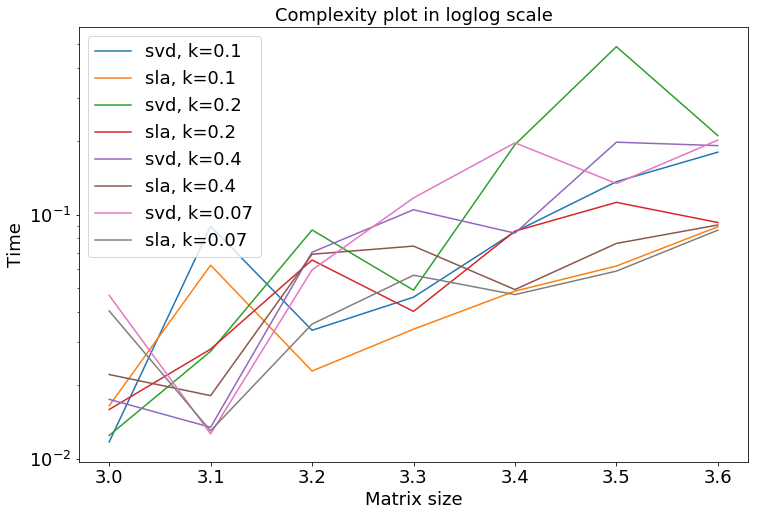

In [88]:
compare_plot(powers_d, k_array_d, svd_time_d, sla_time_d)

In [89]:
def compare_plot(powers, k_array, svd_time, sla_time):
    plt.figure(figsize=(12,8))
    for i in range(len(k_array)):
        plt.plot(powers, svd_time[:,i], label='svd, k={}'.format(k_array[i]))
        plt.plot(powers, sla_time[:,i], label='sla, k={}'.format(k_array[i]))
    plt.yscale('log')
    plt.legend(fontsize=18)
    plt.title("Complexity plot in loglog scale", fontsize=18)
    plt.ylabel('Time',fontsize=18)
    plt.xlabel('Matrix size',fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid()
    plt.show()

In [52]:
powers, k_array, svd_time, sla_time = genenerate_time_matrices(k_array=10,l=20,delta=[.1,.2],n_repeats=10)

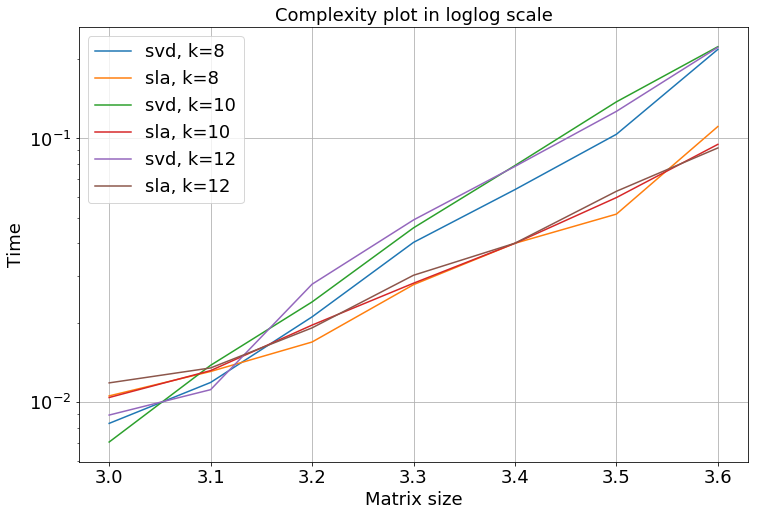

In [90]:
compare_plot(powers, [8,10,12], svd_time, sla_time)

## Applications

### 1. Background/Foreground separation

In [10]:
def load_sequence_video(path, start, stop):
    
    files = sorted(os.listdir(path))
    frame = Image.open(os.path.join(path, files[0]))
    frame = frame.convert("L")
    frame = np.array(frame)
    
    frame_size = frame.shape
    size = frame.shape[0] * frame.shape[1]

    M = np.zeros((size, stop - start), np.float32)
    
    for i in range(start, stop):
        frame = Image.open(os.path.join(path, files[i])).convert("L")
        frame = np.array(frame) / 255.0
        M[:, i] = frame.reshape(-1)
    
    return M, frame_size

def display_result_video(M, L, S, idx):
    n = M.shape[2]
    
    for i in idx:
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1, 3, 1)
        plt.imshow(M[:,:,i], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(L[:,:,i], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(S[:,:,i], cmap='gray')
        plt.axis('off')

videos = [
            "./videos/Bootstrap",
            "./videos/Camouflage",
            "./videos/ForegroundAperture",
            "./videos/LightSwitch",
            "./videos/MovedObject",
            "./videos/TimeOfDay",
            "./videos/WavingTrees"
         ]

start = 0
stop = 3050
M_video, frame_size_video = load_sequence_video(videos[0], start, stop)

In [11]:
%%time

delta = 0.5
l = 10
k = 1

M_video = M_video.astype(np.float64)
m, n = M_video.shape
M_cols = gen_columns(M_video)

res_video = SLA(M_cols, m, n, k, delta, l)

CPU times: user 10.6 s, sys: 580 ms, total: 11.1 s
Wall time: 3.04 s


In [12]:
print("Approximated matrix rank:", np.linalg.matrix_rank(res_video))

Approximated matrix rank: 1


### Save videos for  separated background and foreground


In [20]:
import os

def save_bmps(dst, M, M_rec, frame_size):
    assert M.shape == M_rec.shape

    for j in range(M_rec.shape[1]):
        back_j = M_rec[:, j].reshape(frame_size)
        back_j = back_j / back_j.max()

        orig_j = M[:, j].reshape(frame_size)

        back_j = back_j * 255
        orig_j = orig_j * 255
        fore_j = np.clip(orig_j - back_j, 0, 255)
        
        full_j = np.concatenate([orig_j, back_j, fore_j], axis=1)
        full_j = Image.fromarray(full_j.astype(np.uint8))
        full_j.save(dst + 'b{0:05d}.bmp'.format(j))

In [21]:
dst = "./original/"

os.makedirs(dst, exist_ok=True)
save_bmps(dst, M_video, res_video, frame_size_video)

In [22]:
%%bash

function make_video {
    ffmpeg -v error -framerate 60 -i $1/b0%04d.bmp -r 60 -y $1.mp4
}

for dir in original; do
    make_video $dir
done

In [21]:
M_video_final = M_video.reshape(*frame_size_video, -1)
L_video_final = res_video.reshape(*frame_size_video, -1)
L_video_final = L_video_final / L_video_final.max()
S_video_final = M_video_final - L_video_final
S_video_final[S_video_final < 0.281 / 2] = 0

print(np.linalg.norm(M_video_final - L_video_final) / np.linalg.norm(M_video_final.shape))
print("Sparsity of matrix S:", np.count_nonzero(S_video_final) / np.prod(S_video_final.shape))

0.28112205562436976
Sparsity of matrix S: 0.06076828893442623


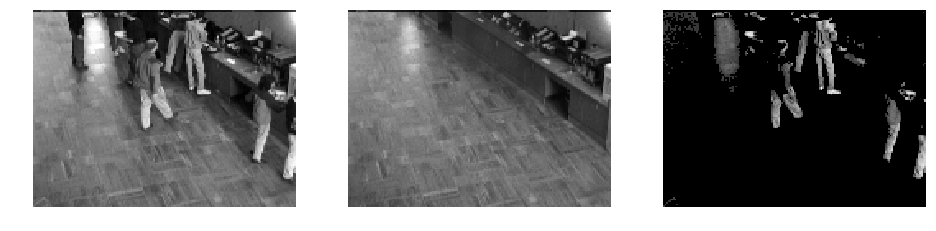

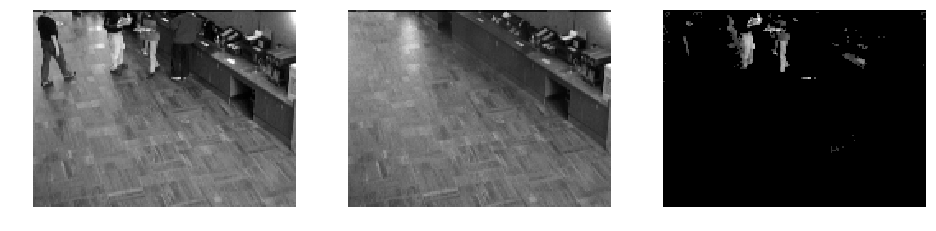

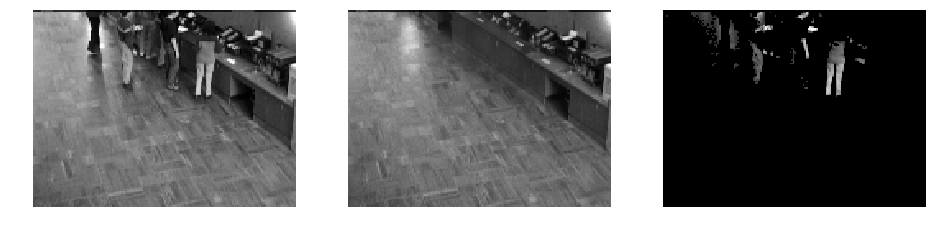

In [22]:
idx = [0, 5, 7]
m = 3
idx = np.random.choice(M_video_final.shape[-1], m)

display_result_video(M_video_final,
                     L_video_final,
                     S_video_final, idx)

### 2. Shadow removing

In [41]:
path = "./CroppedYale/yaleB02"

def load_sequence_faces(path):
    files = sorted(os.listdir(path))[-58:]
    frame = Image.open(os.path.join(path, files[25]))

    frame = np.array(frame)
    frame_size = frame.shape
    size = frame.shape[0] * frame.shape[1]

    M = np.zeros((size, len(files)))
    
    for i in range(len(files)):
        frame = Image.open(os.path.join(path, files[i]))
        frame = np.array(frame) / 255.0
        M[:, i] = frame.reshape(-1)
    
    return M, frame_size

M_faces, frame_size_faces = load_sequence_faces(path)

In [86]:
%%time

delta = 0.9
l = 5
k = 1

M_faces = M_faces.astype(np.float64)
m, n = M_faces.shape
M_cols = gen_columns(M_faces)

res_faces = SLA(M_cols, m, n, k, delta, l)

k  1
l  5
rank A_b1: 5
rank A_b2: 5
rank W: 1
rank Q: 1
rank V: 1
rank I: 1
R shape (1, 1)
CPU times: user 632 ms, sys: 15.8 ms, total: 648 ms
Wall time: 107 ms


In [87]:
M_faces_final = M_faces.reshape(*frame_size_faces, -1)
L_faces_final = res_faces.reshape(*frame_size_faces, -1)
L_faces_final = L_faces_final / L_faces_final.max()
S_faces_final = np.maximum(0, M_faces_final - L_faces_final)

In [ ]:
def display_result_faces(M, L, S, idx):
    n = M.shape[2]
    
    for i in idx:
        plt.figure(figsize=(10, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(M[:,:,i], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(L[:,:,i], cmap='gray')
        plt.axis('off')

In [ ]:
idx = [0, 5, 7]
m = 3
idx = np.random.choice(M_faces_final.shape[-1], m)

display_result_faces(M_faces_final,
                     L_faces_final,
                     S_faces_final, idx)